In [1]:
import os, glob, shutil, math, json, datetime
from pathlib import Path

import numpy as np
import PIL.Image as Image
from PIL import UnidentifiedImageError
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from collections import defaultdict


In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


The code will run on GPU.


In [3]:
# Colab Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# Utils
def timestamp():
    return datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

OUTDIR = Path(f"/content/outputs/{timestamp()}")
OUTDIR.mkdir(parents=True, exist_ok=True)
print("Saving artifacts to:", OUTDIR)

Saving artifacts to: /content/outputs/20250924_164252


In [5]:
# Cell 2: config
ROOT = Path('/content/drive/MyDrive/IDLCV/hotdog_nothotdog')  # 数据根目录（含 train/ test/）
IMG = 224                 # 也可用 128
BATCH = 64
WORKERS = 2

# 训练配置
EPOCHS = 10
LR = 1e-3
OPTIMIZER = 'adam'        # 'adam' or 'sgd'
SCHEDULER = 'cosine'      # 'cosine' or 'step'

# 归一化与增强
USE_DATASET_NORM = False   # True=用训练集统计的 mean/std；False=用 ImageNet 常量
# AUGMENT_KEY = "G_hflip_P_light_R_erasing"
AUGMENT_KEY = "Baseline_RESIZE"


# 显著图
SALIENCY_K = 8
SALIENCY_SIGMA = 0.15
SALIENCY_N = 20


In [6]:
# dataset class
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path=ROOT):
        self.transform = transform
        data_path = os.path.join(str(data_path), 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path+'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c:i for i,c in enumerate(image_classes)}
        # 匹配多种扩展名
        self.image_paths = []
        for ext in ('*.jpg','*.jpeg','*.png','*.JPG','*.JPEG','*.PNG'):
            self.image_paths += glob.glob(os.path.join(data_path, '*', ext))
        self.image_paths.sort()

    def __len__(self): return len(self.image_paths)

    def __getitem__(self, idx):
        p = self.image_paths[idx]
        with Image.open(p) as im:
            im = im.convert('RGB')
        c = os.path.split(os.path.split(p)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(im)
        return X, y


In [7]:
# scan & clean
def scan_and_clean_dataset(root):
    root = Path(root)
    broken_dir = root / "_broken"
    broken_dir.mkdir(exist_ok=True)

    stats = {}
    bad_files = []

    for split in ['train', 'test']:
        stats[split] = {}
        split_dir = root / split
        classes = [d.name for d in split_dir.iterdir() if d.is_dir()]
        for c in sorted(classes):
            cls_dir = split_dir / c
            files = sum([list(cls_dir.glob(pat)) for pat in ('*.jpg','*.jpeg','*.png','*.JPG','*.JPEG','*.PNG')], [])
            ok = 0
            for fp in files:
                try:
                    with Image.open(fp) as im:
                        im.verify()
                    ok += 1
                except (UnidentifiedImageError, OSError):
                    bad_files.append(fp)
            stats[split][c] = ok

    for fp in bad_files:
        target = broken_dir / fp.name
        shutil.move(str(fp), target)

    print(f"[SCAN] Done. Moved {len(bad_files)} broken files to: {broken_dir}")
    return stats

def pretty_print_stats(stats):
    print("Dataset summary:")
    for split, d in stats.items():
        total = sum(d.values())
        print(f"  {split}: total={total}")
        for c, n in d.items():
            print(f"    - {c}: {n}")

stats = scan_and_clean_dataset(ROOT)
pretty_print_stats(stats)


[SCAN] Done. Moved 0 broken files to: /content/drive/MyDrive/IDLCV/hotdog_nothotdog/_broken
Dataset summary:
  train: total=2047
    - hotdog: 1075
    - nothotdog: 972
  test: total=1862
    - hotdog: 895
    - nothotdog: 967


In [8]:
# ===== Cell 5: compute mean/std =====
import torchvision.transforms as T

@torch.no_grad()
def calc_mean_std(loader, max_batches=None):
    psum = torch.zeros(3); psq = torch.zeros(3); cnt = 0
    for i, (x, _) in enumerate(loader):
        if max_batches is not None and i >= max_batches: break
        b,c,h,w = x.shape
        x = x.view(b, c, -1)
        psum += x.sum(dim=[0,2])
        psq  += (x**2).sum(dim=[0,2])
        cnt  += b*h*w
    mean = psum / cnt
    var  = psq  / cnt - mean**2
    std  = torch.sqrt(var.clamp_min(1e-12))
    return mean.tolist(), std.tolist()

# 暂时先不Normalize，只Resize+ToTensor便于统计
pre_tfms = T.Compose([T.Resize(256), T.CenterCrop(IMG), T.ToTensor()])
tmp_loader = DataLoader(Hotdog_NotHotdog(train=True, transform=pre_tfms, data_path=ROOT),
                        batch_size=64, shuffle=False, num_workers=WORKERS)

if USE_DATASET_NORM:
    TRAINSET_MEAN, TRAINSET_STD = calc_mean_std(tmp_loader)
    EVALSET_MEAN,   EVALSET_STD = TRAINSET_MEAN, TRAINSET_STD
else:
    TRAINSET_MEAN, TRAINSET_STD = [0.485,0.456,0.406], [0.229,0.224,0.225]
    EVALSET_MEAN,   EVALSET_STD = TRAINSET_MEAN, TRAINSET_STD

print("mean:", TRAINSET_MEAN, "std:", TRAINSET_STD)
with open(OUTDIR/"norm.json","w") as f:
    json.dump({"mean":TRAINSET_MEAN,"std":TRAINSET_STD}, f, indent=2)


mean: [0.485, 0.456, 0.406] std: [0.229, 0.224, 0.225]


In [12]:
# Cell 6: augmentation dictionary + eval transform
def build_transforms(img_size=IMG, augment_key="Baseline_RESIZE"):
    base_tfms_list = [transforms.RandomResizedCrop(img_size, scale=(1.0,1.0))]
    common_train = [transforms.ToTensor(), transforms.Normalize(TRAINSET_MEAN, TRAINSET_STD)]

    eval_tfms = transforms.Compose([
        transforms.Resize(256), transforms.CenterCrop(img_size),
        transforms.ToTensor(), transforms.Normalize(EVALSET_MEAN, EVALSET_STD)
    ])

    train_tfms = {
        "Baseline_RESIZE": transforms.Compose([transforms.Resize(256), transforms.CenterCrop(img_size),
                                               transforms.ToTensor(), transforms.Normalize(TRAINSET_MEAN, TRAINSET_STD)]),
        "Baseline": transforms.Compose(base_tfms_list + common_train),
        "G_hflip": transforms.Compose(base_tfms_list + [transforms.RandomHorizontalFlip(0.5)] + common_train),
        "G_rot": transforms.Compose(base_tfms_list + [transforms.RandomRotation(10, fill=0)] + common_train),
        "P_light": transforms.Compose(base_tfms_list + [transforms.RandomApply([transforms.ColorJitter(0.15,0.15,0.15,0.03)], p=0.4)] + common_train),
        "P_med": transforms.Compose(base_tfms_list + [transforms.RandomApply([transforms.ColorJitter(0.3,0.3,0.3,0.08)], p=0.6)] + common_train),
        "G_gaussian_blur": transforms.Compose(base_tfms_list + [transforms.GaussianBlur(kernel_size=(5,5), sigma=(0.1,2.0))] + common_train),
        "R_erasing": transforms.Compose(base_tfms_list + [transforms.RandomHorizontalFlip(0.5)] + common_train + [
            transforms.RandomErasing(p=0.1, scale=(0.02,0.12), ratio=(0.3,3.3), inplace=False)
        ]),
        "G_hflip_P_light_R_erasing": transforms.Compose(base_tfms_list + [
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomApply([transforms.ColorJitter(0.15,0.15,0.15,0.03)], p=0.4),
        ] + common_train + [
            transforms.RandomErasing(p=0.1, scale=(0.02,0.12), ratio=(0.3,3.3), inplace=False)
        ]),
        "A_autoaugment": transforms.Compose([
            transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
            transforms.Resize(256), transforms.CenterCrop(img_size),
            transforms.ToTensor(), transforms.Normalize(TRAINSET_MEAN, TRAINSET_STD),
        ]),
        "A_randaugment": transforms.Compose([
            transforms.RandAugment(num_ops=2, magnitude=9),
            transforms.Resize(256), transforms.CenterCrop(img_size),
            transforms.ToTensor(), transforms.Normalize(TRAINSET_MEAN, TRAINSET_STD),
        ]),
    }
    if augment_key not in train_tfms:
        raise KeyError(f"{augment_key} not in {list(train_tfms.keys())}")
    return train_tfms[augment_key], eval_tfms

train_transform, test_transform = build_transforms(IMG, AUGMENT_KEY)
print("Using augmentation:", AUGMENT_KEY)


Using augmentation: Baseline_RESIZE


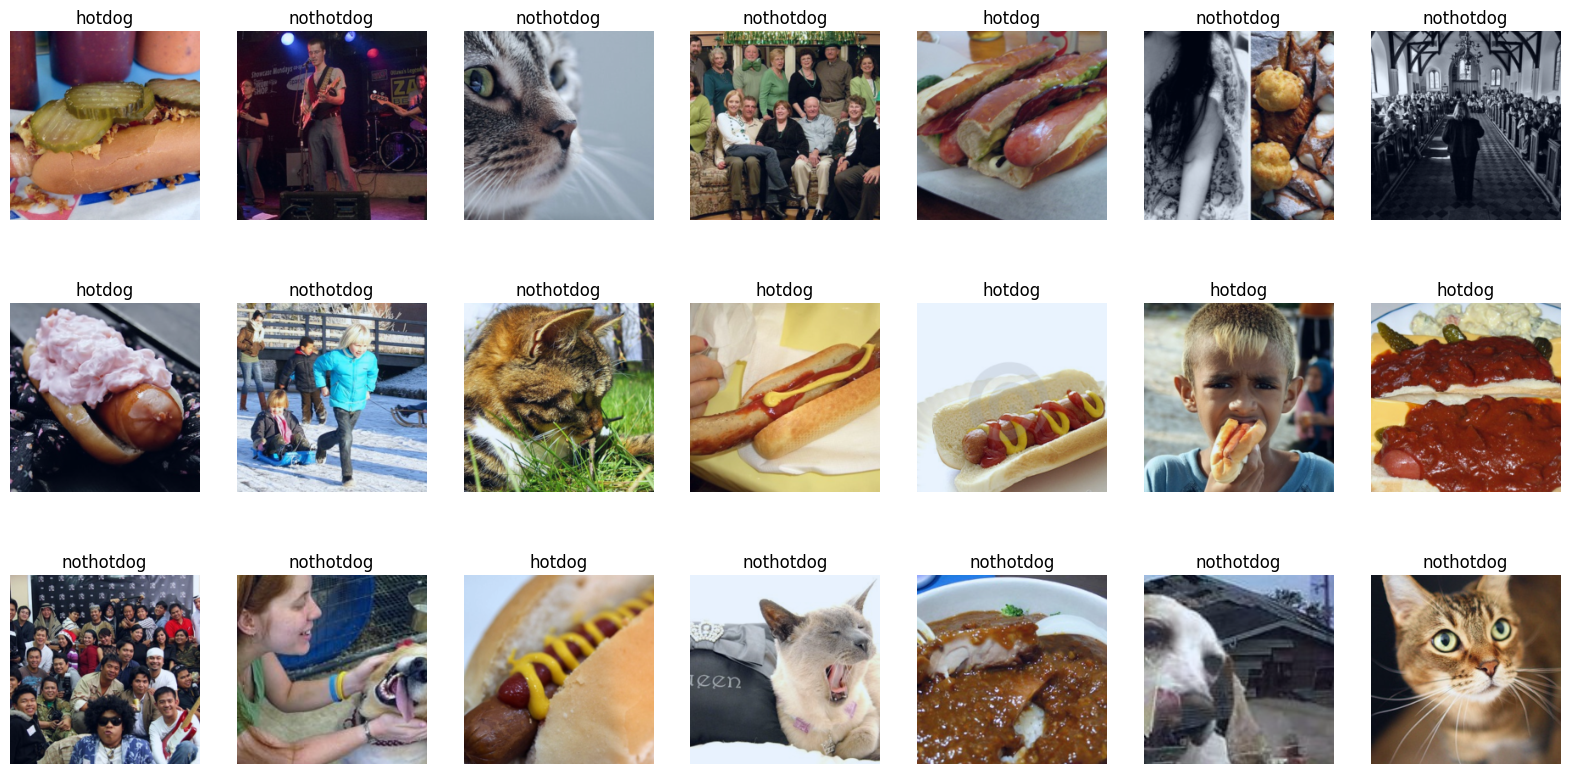

In [13]:
# Cell 7: loaders
trainset = Hotdog_NotHotdog(train=True,  transform=train_transform, data_path=ROOT)
testset  = Hotdog_NotHotdog(train=False, transform=test_transform,  data_path=ROOT)

train_loader = DataLoader(trainset, batch_size=BATCH, shuffle=True,  num_workers=WORKERS)
test_loader  = DataLoader(testset,  batch_size=BATCH, shuffle=False, num_workers=WORKERS)

# 简单可视化
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))
names = [k for k,_ in sorted(trainset.name_to_label.items(), key=lambda kv: kv[1])]
for i in range(min(21, images.size(0))):
    plt.subplot(3,7,i+1); img = (images[i]-images[i].min())/(images[i].max()-images[i].min()+1e-6)
    plt.imshow(img.permute(1,2,0)); plt.title(names[labels[i].item()]); plt.axis('off')
plt.show()


In [14]:
# Cell 8: models
from torchvision import models

class SmallCNN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64,128,3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(), nn.Linear(128*(IMG//8)*(IMG//8), 128), nn.ReLU(), nn.Linear(128, 2)
        )
    def forward(self, x): return self.classifier(self.features(x))

def build_model(kind='base', num_classes=2, pretrained=True, freeze_backbone=False):
    if kind == 'base':
        model = SmallCNN(num_classes=num_classes)
    elif kind == 'resnet18':
        m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
        if freeze_backbone:
            for p in m.parameters(): p.requires_grad = False
        m.fc = nn.Linear(m.fc.in_features, num_classes)
        model = m
    else:
        raise ValueError("Unknown kind")
    return model.to(device)


In [15]:
# Cell 9: training loop (yours, unchanged)
def accuracy_from_logits(logits, y):
    pred = logits.argmax(dim=1)
    return (pred == y).float().mean().item()

def train_one_model(kind='base', epochs=10, lr=1e-3, optimizer_name='adam',
                    scheduler_name='cosine', patience=5, freeze_backbone=False):
    model = build_model(kind, num_classes=2, pretrained=True, freeze_backbone=freeze_backbone)

    if optimizer_name.lower() == 'adam':
        opt = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name.lower() == 'sgd':
        opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)
    else:
        raise ValueError("optimizer_name in {'adam','sgd'}")

    if scheduler_name == 'cosine':
        sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)
    elif scheduler_name == 'step':
        sched = torch.optim.lr_scheduler.StepLR(opt, step_size=max(1,epochs//3), gamma=0.1)
    else:
        sched = None

    scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))
    criterion = nn.CrossEntropyLoss()
    hist = defaultdict(list); best_val_acc = 0.0; best_state = None; wait = 0

    for ep in range(1, epochs+1):
        model.train(); train_loss=train_acc=0.0; n_train=0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device, dtype=torch.long)
            opt.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
                logits = model(X); loss = criterion(logits, y)
            scaler.scale(loss).backward(); scaler.step(opt); scaler.update()
            if sched and isinstance(sched, torch.optim.lr_scheduler.CosineAnnealingLR): sched.step()
            train_loss += loss.item()*X.size(0); train_acc += (logits.argmax(1)==y).sum().item(); n_train += X.size(0)
        # if sched and not isinstance(sched, torch.optim.lr_scheduler.CosineAnnealingLR): sched.step()

        if sched:
          sched.step()

        model.eval(); val_loss=val_acc=0.0; n_val=0
        with torch.no_grad():
            for X,y in test_loader:
                X, y = X.to(device), y.to(device, dtype=torch.long)
                logits = model(X); loss = criterion(logits, y)
                val_loss += loss.item()*X.size(0); val_acc += (logits.argmax(1)==y).sum().item(); n_val += X.size(0)

        train_loss/=max(1,n_train); val_loss/=max(1,n_val)
        train_acc /=max(1,n_train); val_acc /=max(1,n_val)
        hist['train_loss'].append(train_loss); hist['val_loss'].append(val_loss)
        hist['train_acc'].append(train_acc);  hist['val_acc'].append(val_acc)

        improved = val_acc > best_val_acc + 1e-4
        if improved:
            best_val_acc = val_acc
            best_state = {k:v.cpu().clone() for k,v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"[EarlyStop] epoch={ep}, best_val_acc={best_val_acc:.4f}")
                break

        print(f"Epoch {ep:03d}  loss {train_loss:.4f}/{val_loss:.4f}  acc {train_acc:.3f}/{val_acc:.3f}")

    if best_state is not None:
        model.load_state_dict(best_state)
        torch.save(best_state, OUTDIR/"best.ckpt")
    return model, hist, best_val_acc

def plot_curves(hists, labels, title="Training curves"):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    for h,lab in zip(hists, labels):
        plt.plot(h['train_loss'], label=f"{lab}-train")
        plt.plot(h['val_loss'],   label=f"{lab}-val", linestyle='--')
    plt.xlabel("epoch"); plt.ylabel("loss"); plt.title(title+" (loss)"); plt.legend(); plt.grid(alpha=0.3)

    plt.subplot(1,2,2)
    for h,lab in zip(hists, labels):
        plt.plot(h['train_acc'], label=f"{lab}-train")
        plt.plot(h['val_acc'],   label=f"{lab}-val", linestyle='--')
    plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.title(title+" (acc)"); plt.legend(); plt.grid(alpha=0.3)
    plt.tight_layout(); plt.savefig(OUTDIR/"curves.png"); plt.show()


/tmp/ipython-input-4177573139.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))
/tmp/ipython-input-4177573139.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Epoch 001  loss 1.3708/0.6205  acc 0.521/0.694
Epoch 002  loss 0.6106/0.5910  acc 0.691/0.718
Epoch 003  loss 0.5262/0.5486  acc 0.748/0.729
Epoch 004  loss 0.5041/0.5506  acc 0.759/0.729
Epoch 005  loss 0.4841/0.5749  acc 0.775/0.741
Epoch 006  loss 0.4309/0.5342  acc 0.796/0.756
Epoch 007  loss 0.3926/0.5536  acc 0.826/0.752
Epoch 008  loss 0.3483/0.5607  acc 0.845/0.747
Epoch 009  loss 0.2849/0.6747  acc 0.892/0.750
Epoch 010  loss 0.2175/0.7220  acc 0.925/0.750
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 127MB/s]


Epoch 001  loss 0.3412/0.3142  acc 0.856/0.888
Epoch 002  loss 0.1147/0.3731  acc 0.958/0.880
Epoch 003  loss 0.0663/0.2972  acc 0.977/0.904
Epoch 004  loss 0.0671/0.3089  acc 0.976/0.898
Epoch 005  loss 0.0662/1.3668  acc 0.979/0.718
Epoch 006  loss 0.0495/0.3260  acc 0.985/0.896
Epoch 007  loss 0.0780/0.3859  acc 0.970/0.883
[EarlyStop] epoch=8, best_val_acc=0.9039


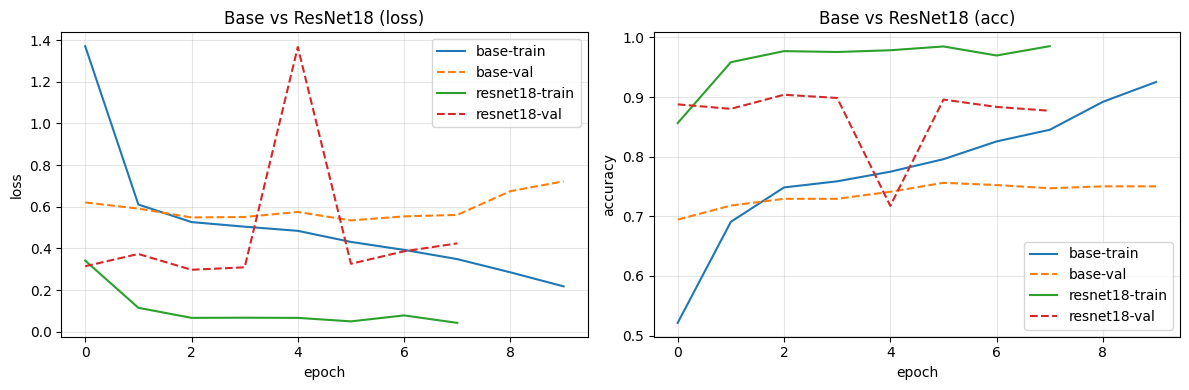

Best val acc  base: 0.756 | resnet18: 0.904


In [16]:
# Cell 10: train runs
epochs = EPOCHS
model_base, hist_base, best_base = train_one_model(kind='base',     epochs=epochs, lr=LR, optimizer_name=OPTIMIZER, scheduler_name=SCHEDULER, patience=5)
model_res , hist_res , best_res  = train_one_model(kind='resnet18', epochs=epochs, lr=LR, optimizer_name=OPTIMIZER, scheduler_name=SCHEDULER, patience=5, freeze_backbone=False)

plot_curves([hist_base, hist_res], ['base', 'resnet18'], title="Base vs ResNet18")
print(f"Best val acc  base: {best_base:.3f} | resnet18: {best_res:.3f}")


== Base model on test ==
Accuracy: 0.7562

              precision    recall  f1-score   support

      hotdog     0.7285    0.7855    0.7559       895
   nothotdog     0.7860    0.7291    0.7564       967

    accuracy                         0.7562      1862
   macro avg     0.7572    0.7573    0.7562      1862
weighted avg     0.7583    0.7562    0.7562      1862



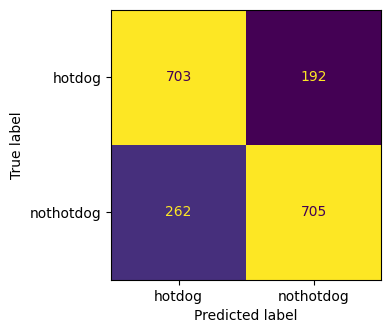

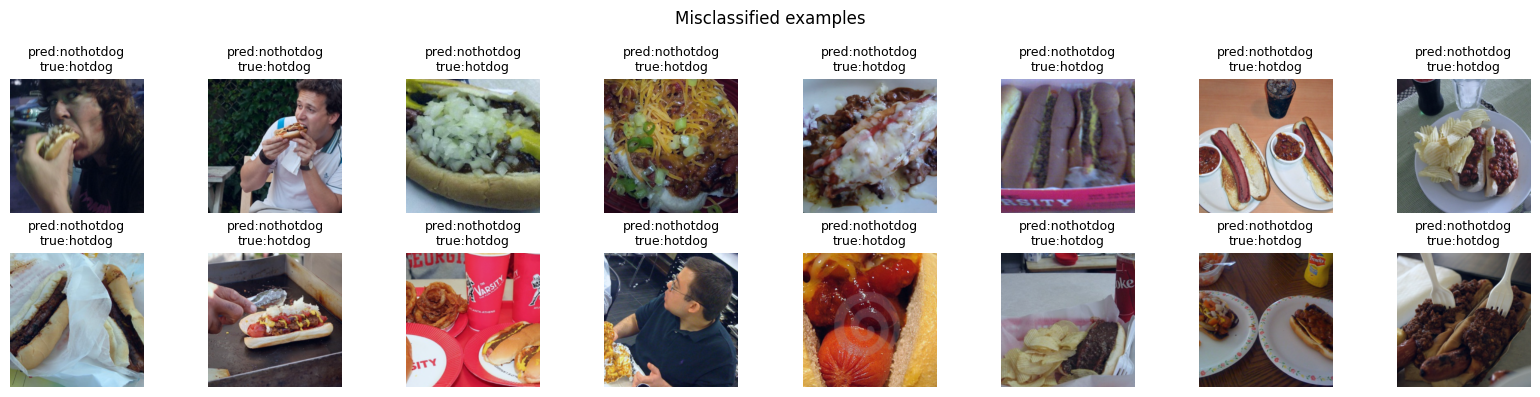


== ResNet18 on test ==
Accuracy: 0.9039

              precision    recall  f1-score   support

      hotdog     0.9077    0.8905    0.8990       895
   nothotdog     0.9004    0.9162    0.9083       967

    accuracy                         0.9039      1862
   macro avg     0.9041    0.9034    0.9036      1862
weighted avg     0.9039    0.9039    0.9038      1862



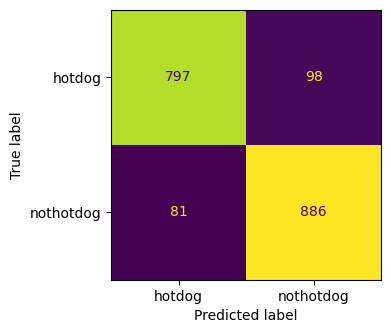

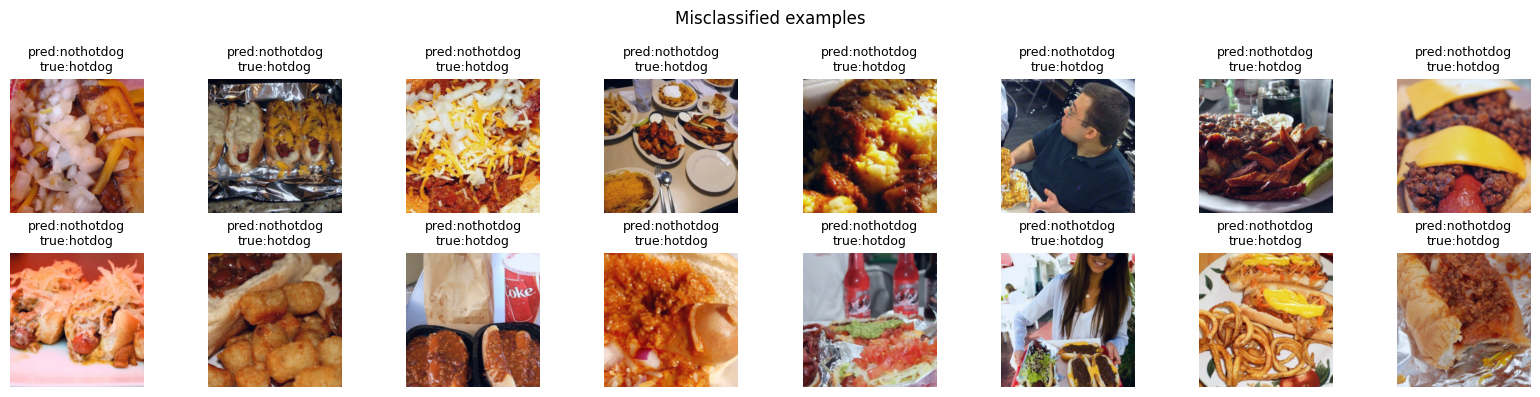

In [17]:
# Cell 11: evaluation & misclassified
def eval_and_report(model, loader, class_names=None, max_show=16):
    model.eval()
    all_y = []; all_p = []
    wrong_imgs = []; wrong_pred_true = []
    with torch.no_grad():
        for X, y in loader:
            X = X.to(device); y = y.to(device)
            logits = model(X)
            p = logits.argmax(1)
            all_y.append(y.cpu().numpy()); all_p.append(p.cpu().numpy())

            mism = (p != y)
            if mism.any():
                xs = X[mism].cpu()
                ys = y[mism].cpu().numpy()
                ps = p[mism].cpu().numpy()
                for i in range(xs.size(0)):
                    if len(wrong_imgs) >= max_show: break
                    wrong_imgs.append(xs[i]); wrong_pred_true.append((ps[i], ys[i]))

    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    acc = (all_y == all_p).mean()
    print(f"Accuracy: {acc:.4f}\n")
    report_txt = classification_report(all_y, all_p, target_names=class_names, digits=4) if class_names else classification_report(all_y, all_p, digits=4)
    print(report_txt)

    # 保存报告
    with open(OUTDIR / "classification_report.txt","w") as f:
        f.write(f"Accuracy: {acc:.4f}\n\n{report_txt}")

    # 混淆矩阵（图 + 保存）
    cm = confusion_matrix(all_y, all_p)
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names if class_names else None)
    fig, ax = plt.subplots(figsize=(4,4)); disp.plot(ax=ax, colorbar=False, values_format='d')
    plt.tight_layout(); plt.savefig(OUTDIR/"confusion_matrix.png"); plt.show()

    # 错误样本可视化
    if wrong_imgs:
        k = min(max_show, len(wrong_imgs)); cols = 8; rows = math.ceil(k/cols)
        plt.figure(figsize=(cols*2, rows*2))
        for i in range(k):
            plt.subplot(rows, cols, i+1)
            img = (wrong_imgs[i]-wrong_imgs[i].min())/(wrong_imgs[i].max()-wrong_imgs[i].min()+1e-6)
            pt = wrong_pred_true[i]
            ttl = f"pred:{class_names[pt[0]] if class_names else pt[0]}\ntrue:{class_names[pt[1]] if class_names else pt[1]}"
            plt.imshow(img.permute(1,2,0)); plt.axis('off'); plt.title(ttl, fontsize=9)
        plt.suptitle("Misclassified examples"); plt.tight_layout(); plt.savefig(OUTDIR/"misclassified.png"); plt.show()
    return acc

class_names = [k for k,_ in sorted(trainset.name_to_label.items(), key=lambda kv: kv[1])]
print("== Base model on test ==")
acc_base = eval_and_report(model_base, test_loader, class_names)

print("\n== ResNet18 on test ==")
acc_res = eval_and_report(model_res,  test_loader, class_names)


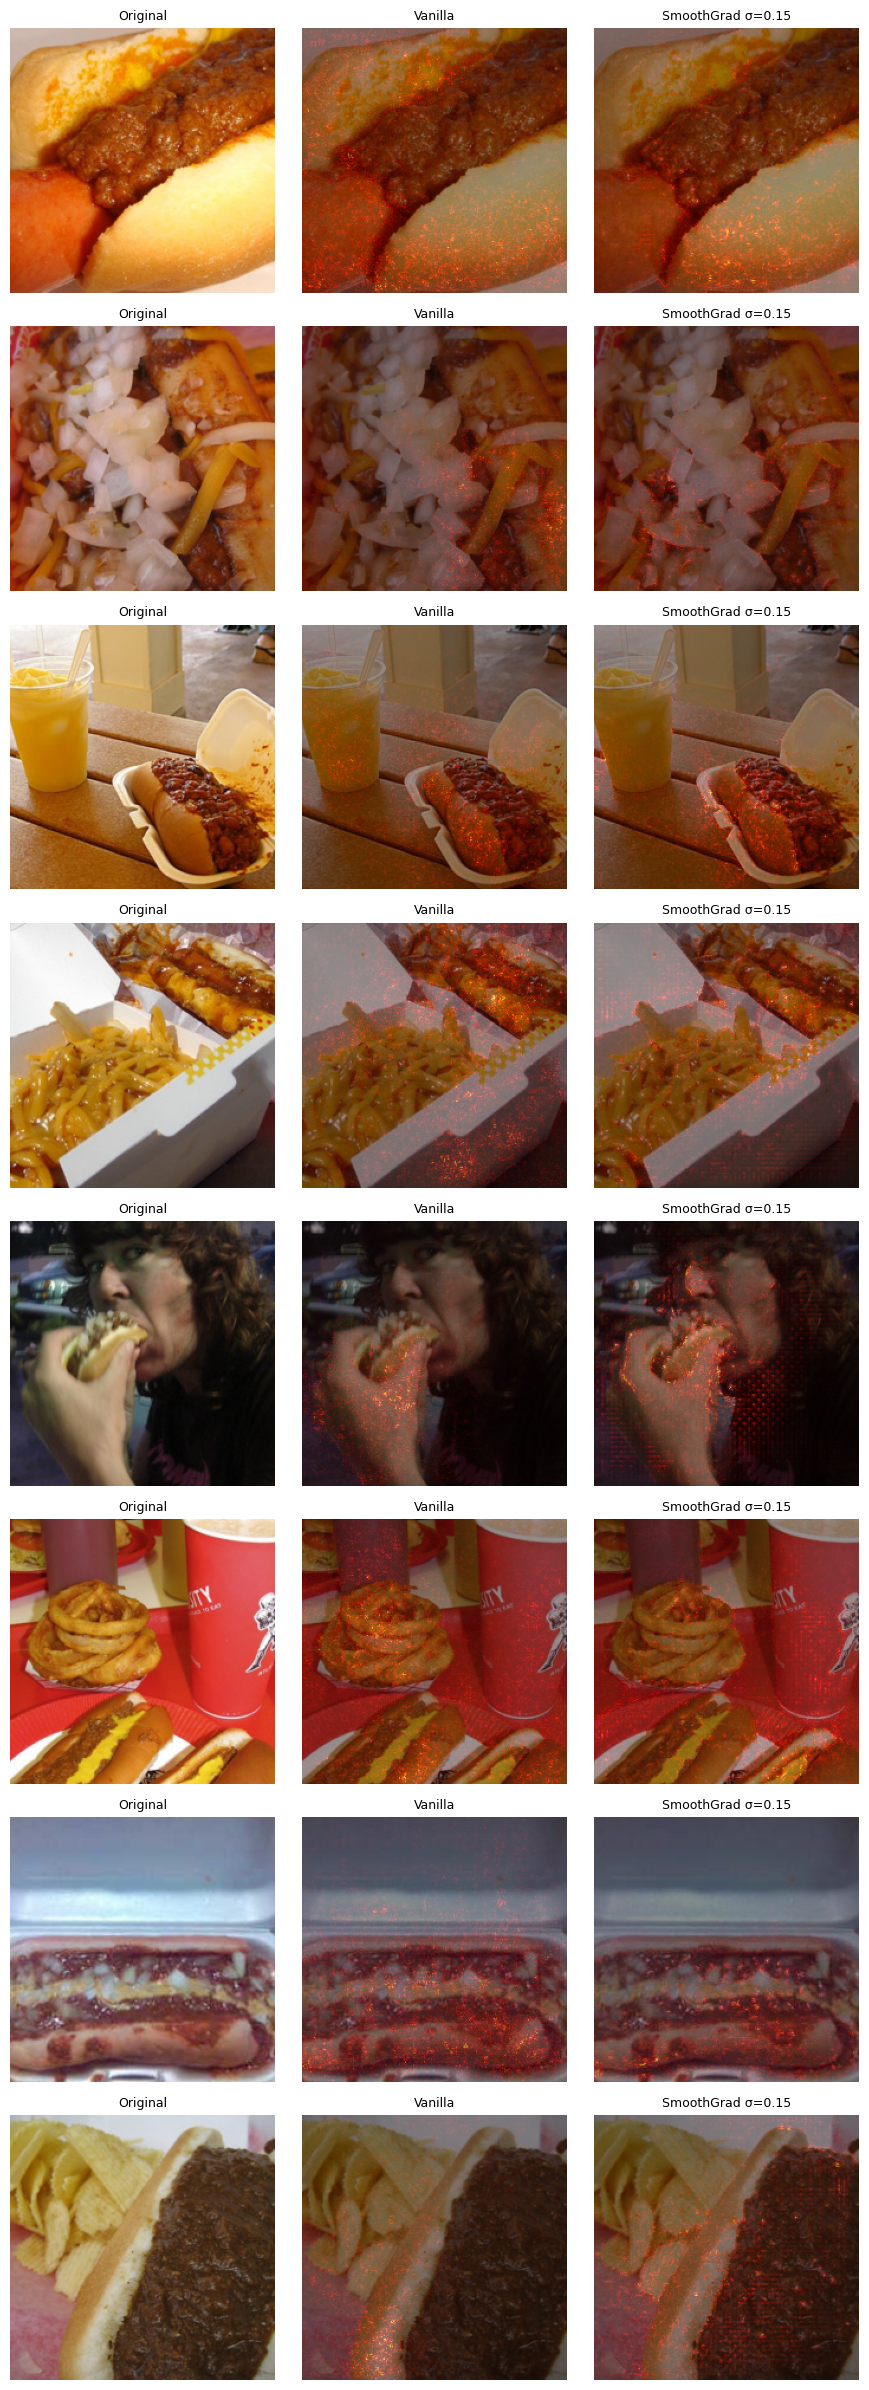

In [18]:
# Cell 12 : saliency (vanilla + smoothgrad)
def denorm(img_chw, mean=TRAINSET_MEAN, std=TRAINSET_STD, enabled=True):
    x = img_chw.detach().cpu().clone()
    if enabled:
        for c, (m, s) in enumerate(zip(mean, std)):
            x[c] = x[c] * s + m
    return x.clamp(0, 1)

def saliency_map(model, img_tensor, target_class=None, take_abs=True, to_numpy=True):
    """
    Vanilla Saliency: d logit_c / d input
    """
    model.eval()
    device = next(model.parameters()).device
    with torch.enable_grad():                               # 显式打开梯度
        x = img_tensor.clone().to(device).unsqueeze(0)      # [1,C,H,W]
        x.requires_grad_(True)
        logits = model(x)                                   # [1,num_classes]
        cls = int(logits.argmax(1).item() if target_class is None else target_class)
        model.zero_grad(set_to_none=True)
        logits[0, cls].backward()                           # d logit_cls / d x
        g = x.grad.detach().squeeze(0)                      # [C,H,W]
    if take_abs:
        g = g.abs()
    sal = g.max(dim=0).values                               # [H,W]
    sal = (sal - sal.min())/(sal.max() + 1e-8)
    return (sal.cpu().numpy() if to_numpy else sal.cpu()), cls

def smoothgrad_saliency(model, img_tensor, target_class=None, n_samples=SALIENCY_N, sigma=SALIENCY_SIGMA):
    """
    SmoothGrad: 对输入多次加噪声，平均梯度。
    """
    model.eval()
    device = next(model.parameters()).device
    x0 = img_tensor.clone().to(device)

    # 先确定目标类别（用预测或用户指定）
    with torch.enable_grad():
        x_tmp = x0.unsqueeze(0).requires_grad_(True)
        logits = model(x_tmp)
        cls = int(logits.argmax(1).item() if target_class is None else target_class)

    acc = torch.zeros_like(x0)
    for _ in range(n_samples):
        with torch.enable_grad():
            xn = (x0 + torch.randn_like(x0)*sigma).clamp(0,1).unsqueeze(0)
            xn.requires_grad_(True)
            model.zero_grad(set_to_none=True)
            s = model(xn)[0, cls]
            s.backward()
            acc += xn.grad.detach().squeeze(0)

    g = acc / max(1, n_samples)
    g = g.abs().max(dim=0).values                           # [H,W]
    g = (g - g.min())/(g.max() + 1e-8)
    return g.cpu().numpy(), cls

def show_saliency_grid_compare(model, loader, class_names=None, k=SALIENCY_K, alpha=0.45, sigma=SALIENCY_SIGMA, n_samples=SALIENCY_N):
    """
    每张图显示：Original | Vanilla | SmoothGrad
    """
    X, y = next(iter(loader))
    k = min(k, X.size(0))
    rows, cols = k, 3
    plt.figure(figsize=(cols*3, rows*3))
    for i in range(k):
        img = X[i]
        van, _ = saliency_map(model, img)
        smg, _ = smoothgrad_saliency(model, img, n_samples=n_samples, sigma=sigma)
        vis = denorm(img).permute(1,2,0).numpy()

        ax = plt.subplot(rows, cols, i*3+1); ax.imshow(vis); ax.axis('off'); ax.set_title("Original", fontsize=9)
        ax = plt.subplot(rows, cols, i*3+2); ax.imshow(vis); ax.imshow(van, cmap='hot', alpha=alpha); ax.axis('off'); ax.set_title("Vanilla", fontsize=9)
        ax = plt.subplot(rows, cols, i*3+3); ax.imshow(vis); ax.imshow(smg, cmap='hot', alpha=alpha); ax.axis('off'); ax.set_title(f"SmoothGrad σ={sigma}", fontsize=9)
    plt.tight_layout(); plt.savefig(OUTDIR/"saliency_grid.png"); plt.show()

# 选择一个模型做可视化（保持你原来的逻辑）
_model_for_vis = model_res if 'model_res' in globals() else model_base
show_saliency_grid_compare(_model_for_vis, test_loader, class_names, k=SALIENCY_K, sigma=SALIENCY_SIGMA, n_samples=SALIENCY_N)


In [20]:
# Cell 13: small grid
def run_experiment_grid(configs, epochs=8):
    results = []; hists = []; labels = []
    for cfg in configs:
        print(f"\n=== {cfg['label']} ===")
        # 切换增强方案
        train_tf, test_tf = build_transforms(IMG, cfg.get('augment_key', AUGMENT_KEY))
        global train_loader, test_loader
        train_loader = DataLoader(Hotdog_NotHotdog(train=True,  transform=train_tf, data_path=ROOT), batch_size=BATCH, shuffle=True,  num_workers=WORKERS)
        test_loader  = DataLoader(Hotdog_NotHotdog(train=False, transform=test_tf, data_path=ROOT), batch_size=BATCH, shuffle=False, num_workers=WORKERS)

        model, hist, best = train_one_model(kind=cfg['kind'], epochs=epochs, lr=cfg['lr'],
                                            optimizer_name=cfg['optimizer'],
                                            scheduler_name=cfg.get('scheduler','cosine'),
                                            patience=cfg.get('patience',5),
                                            freeze_backbone=cfg.get('freeze',False))
        results.append((cfg['label'], best)); hists.append(hist); labels.append(cfg['label'])
    plot_curves(hists, labels, title="Grid comparison")
    print("Summary best val acc:");
    for name, b in results: print(f"  {name}: {b:.3f}")

# 示例（按需运行）
# grid = [
#     {'label':'base+adam',      'kind':'base',     'optimizer':'adam', 'lr':1e-3, 'augment_key':'Baseline'},
#     {'label':'resnet18+adam',  'kind':'resnet18', 'optimizer':'adam', 'lr':1e-3, 'augment_key':'G_hflip_P_light_R_erasing'},
#     {'label':'resnet18+sgd',   'kind':'resnet18', 'optimizer':'sgd',  'lr':1e-2, 'augment_key':'A_randaugment'},
# ]
# run_experiment_grid(grid, epochs=8)
